# Taxi Driver Program
Reinforcement Learning algorithm that solves the Taxi-v3 environment from OpenAI gym library

### Two possible modes:
1. User mode: Input parameters to play with optimization
2. Time mode: Input time for algorithm to find a solution

## Functionality
Run all cells, and then go to Program Frontend heading to run desired game mode.
Each mode contains instructions in documentation string

## Training

In [1]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns

In [2]:
env = gym.make('Taxi-v3')
env.reset()
env.render()
action_size = env.action_space.n
state_size = env.observation_space.n

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
# DEFAULT PARAMS
TOTAL_TEST_EP = 100
TOTAL_EP = 1500
MAX_STEPS = 100
LR = 0.81
GAMMA = 0.96
EPSILON = 0.9
MAX_EPSILON = 1.0
MIN_EPSILON = 0.01
DECAY_RATE = 0.01


In [4]:
# MODEL INFERENCE RESULTS
rewards_total = []
steps_total = []
penalties_per_ep_total = []
timestep_per_ep_total = []

# MODEL TRAINING RESULTS
train_rewards_per_ep_total = []
train_penalties_per_ep_total = []
train_timestep_per_ep_total = []

# MODEL EVALUATION METRICS
reward_zero_crossing_point = []
max_cost = []


# Q table
q_table = np.zeros((state_size, action_size))

In [5]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def show_run_stats(rewards, penalties, steps, timesteps):
    # Rewards over episodes
    plt.figure(figsize=(12,5))
    plt.title("Rewards over episodes")
    plt.bar(torch.arange(len(rewards)), rewards, alpha=0.6, color='green', width=5)
    ma = moving_average(rewards, n=15)
    plt.plot(torch.arange(len(ma)), ma)
    # plt.plot()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.title("Steps over episode")
    # plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='red', width=5)
    plt.bar(torch.arange(len(steps)), steps)
    plt.show()

    plt.figure(figsize=(12,5))
    plt.title("Penalties per episode")
    plt.plot(torch.arange(len(penalties)), penalties)
    plt.show()

    plt.figure(figsize=(12,5))
    plt.title("Timestep per episode")
    # plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='red', width=5)
    plt.plot(torch.arange((len(timesteps))), timesteps)
    plt.show()

In [6]:
def calculate_q_table(
    total_ep = TOTAL_EP,
    max_steps = MAX_STEPS,
    lr = LR,
    gamma = GAMMA,
    epsilon = EPSILON,
    max_epsilon = MAX_EPSILON,
    min_epsilon = MIN_EPSILON,
    decay_rate = DECAY_RATE
):
    '''
    Run training on taxi env to calculate Q-table
    :param total_ep:
    :param max_steps:
    :param lr:
    :param gamma:
    :param epsilon:
    :param max_epsilon:
    :param min_epsilon:
    :param decay_rate:
    :return:
    '''
    global train_rewards_per_ep_total
    global train_penalties_per_ep_total
    global train_timestep_per_ep_total
    global max_cost
    # global reward_zero_crossing_point
    train_rewards_per_ep_total = []
    train_penalties_per_ep_total = []
    train_timestep_per_ep_total = []
    max_cost = 0
    # reward_zero_crossing_point = 0

    for episode in range(total_ep):

      # Reset Environment:
      state = env.reset()
      step = 0
      done = False

      total_penalties_in_episode = 0
      total_rewards_in_episode = 0

      for step in range(max_steps):

        # Choose an action a in the current world state(s) (step 3)
        # First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)

        # If this number > greater than epsilon --> exploitation (taking the biggest q value for the current state):
        if exp_exp_tradeoff > epsilon:
          action = np.argmax(q_table[state, :])

        # Else, doing random choice:
        else:
          action = env.action_space.sample()

        # Take the action (a) and observe the outcome state (s') and the reward (r)
        new_state, reward, done, info = env.step(action)

        if reward == -10:
            total_penalties_in_episode += 1

        if reward < max_cost:
            max_cost = reward


        total_rewards_in_episode += reward

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        q_table[state, action] = q_table[state, action] + lr * (reward + gamma *
                                        np.max(q_table[new_state, :]) - q_table[state, action])

        # Our new state:
        state = new_state

        # If done True, finish the episode:
        if done:
            train_rewards_per_ep_total.append(total_rewards_in_episode)
            train_penalties_per_ep_total.append(total_penalties_in_episode)
            train_timestep_per_ep_total.append(step)
            break

      # Increment number of episodes:
      episode += 1

      # Reduce epsilon (because we need less and less exploration):
      epsilon = min_epsilon + (max_epsilon - min_epsilon) *np.exp(-decay_rate*episode)

    return train_timestep_per_ep_total, train_penalties_per_ep_total, max_cost

## Optimization

In [29]:
def gridsearch(lr_range, gamma_range, epsilon_range):
    '''
    Run a gridsearch on Q-Learning to output best combination
    :param lr_range: range to test learning rate
    :param gamma_range: range to test gamma
    :param epsilon_range: range to test epsilon
    :return:
    '''
    results = pd.DataFrame()

    for lr in lr_range:
        for gamma in gamma_range:
            for epsilon in epsilon_range:
                timestep, penalties, cost = calculate_q_table(
                    lr=lr,
                    gamma=gamma,
                    epsilon=epsilon
                )
                results_ = pd.DataFrame({
                    'learning_rate':  float(lr),
                    'gamma':  float(gamma),
                    'epsilon':  float(epsilon),
                    'timesteps':  timestep,
                    'penalties':  penalties,
                    'cost':  cost,
                })
                
                results = results.append(results_)

    # index -> episode
    results = results.reset_index().rename(columns={'index': 'episode'})

    # add column with the 2 hyper-parameters
    results['hyperparameters'] = [f'lr={l}, gamma={g}, epsilon={e}' for (l, g, e) in zip(results['learning_rate'], results['gamma'], results['epsilon'])]

    print(results.head())


    return results

   episode  learning_rate  gamma  epsilon  timesteps  penalties  cost  \
0        0            0.7    0.7      0.7         34         10   -10   
1        1            0.7    0.7      0.7         67         23   -10   
2        2            0.7    0.7      0.7         49          7   -10   
3        3            0.7    0.7      0.7         49         10   -10   
4        4            0.7    0.7      0.7         35          8   -10   

                  hyperparameters  
0  lr=0.7, gamma=0.7, epsilon=0.7  
1  lr=0.7, gamma=0.7, epsilon=0.7  
2  lr=0.7, gamma=0.7, epsilon=0.7  
3  lr=0.7, gamma=0.7, epsilon=0.7  
4  lr=0.7, gamma=0.7, epsilon=0.7  


/Users/ryanheadley/.pyenv/versions/3.9.7/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='episode', ylabel='timesteps'>

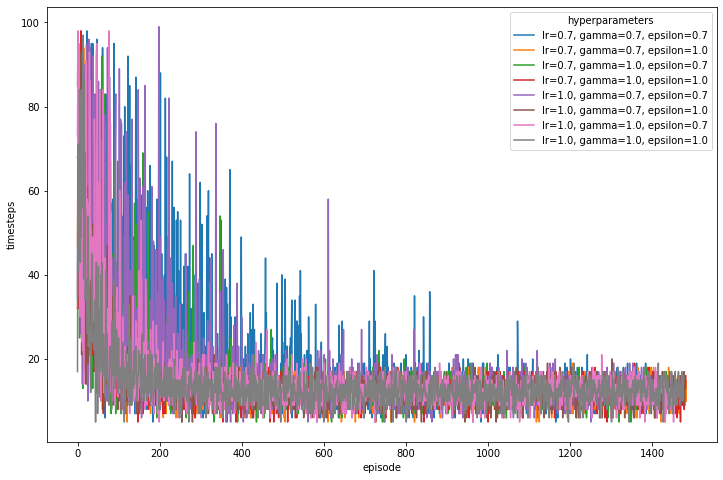

In [35]:
r = gridsearch(
    lr_range=np.linspace(0.7,1.0, num=2),
    gamma_range=np.linspace(0.7,1.0, num=2),
    epsilon_range=np.linspace(0.7,1.0, num=2)
)
fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'timesteps', hue='hyperparameters', data=r)

In [37]:
r.sort_values(by=['timesteps'])

,episode,learning_rate,gamma,epsilon,timesteps,penalties,cost,hyperparameters
7495,280,1.0,0.7,1.0,5,0,-10,"lr=1.0, gamma=0.7, epsilon=1.0"
364,364,0.7,0.7,0.7,5,0,-10,"lr=0.7, gamma=0.7, epsilon=0.7"
1999,610,0.7,0.7,1.0,5,0,-10,"lr=0.7, gamma=0.7, epsilon=1.0"
10755,600,1.0,1.0,1.0,5,0,-10,"lr=1.0, gamma=1.0, epsilon=1.0"
4476,147,0.7,1.0,1.0,5,0,-10,"lr=0.7, gamma=1.0, epsilon=1.0"
...,...,...,...,...,...,...,...,...
8773,77,1.0,1.0,0.7,98,13,-10,"lr=1.0, gamma=1.0, epsilon=0.7"
8697,1,1.0,1.0,0.7,98,28,-10,"lr=1.0, gamma=1.0, epsilon=0.7"
4337,8,0.7,1.0,1.0,98,18,-10,"lr=0.7, gamma=1.0, epsilon=1.0"
23,23,0.7,0.7,0.7,98,12,-10,"lr=0.7, gamma=0.7, epsilon=0.7"


## Inference

In [37]:
def run_taxi_driver_with_calculated_q_table(
        total_test_ep=TOTAL_TEST_EP,
        max_steps=MAX_STEPS
):
    '''
    Run the taxi game with the existing q-table
    :param total_test_ep: Total episodes to run
    :param max_steps: Max steps per episode
    :return:
    '''
    if not np.any(q_table):
        calculate_q_table()

    env.reset()
    rewards = []

    for episode in range(total_test_ep):
      state = env.reset()
      step = 0
      done = False
      total_rewards = 0
      total_penalties = 0
      total_timestep = 0
      print('=========================')
      print('EPISODE: ', episode)

      for step in range(max_steps):

        env.render()

        # Take the action based on the Q Table:
        action = np.argmax(q_table[state, :])

        new_state, reward, done, info = env.step(action)

        total_rewards += reward
        total_timestep += 1

        if reward == -10:
            print("PENALTY")
            total_penalties += 1

        # If episode finishes:
        if done:
            steps_total.append(step)
            rewards_total.append(total_rewards)
            timestep_per_ep_total.append(total_timestep)
            penalties_per_ep_total.append(total_penalties)
            # egreedy_total.append(egreedy)
            print('Score: ', total_rewards)
            break

        state = new_state

    env.close()
    print('Score Over Time: {}'.format(sum(rewards)/total_test_ep))


## Program Backend

In [38]:
def run_program():
    run_taxi_driver_with_calculated_q_table()
    pass

def user_mode(
    total_ep = TOTAL_EP,
    max_steps = MAX_STEPS,
    lr = LR,
    gamma = GAMMA,
    epsilon = EPSILON,
    max_epsilon = MAX_EPSILON,
    min_epsilon = MIN_EPSILON,
    decay_rate = DECAY_RATE
):
    calculate_q_table(
        total_ep = total_ep,
        max_steps = max_steps,
        lr = lr,
        gamma = gamma,
        epsilon = epsilon,
        max_epsilon = max_epsilon,
        min_epsilon = min_epsilon,
        decay_rate = decay_rate
    )
    run_taxi_driver_with_calculated_q_table()
    pass

def time_mode(steps=TOTAL_TEST_EP):
    run_taxi_driver_with_calculated_q_table(steps)
    pass

In [39]:
def train():
    calculate_q_table()
    show_run_stats(train_rewards_per_ep_total, train_penalties_per_ep_total,
                   train_penalties_per_ep_total, train_timestep_per_ep_total)

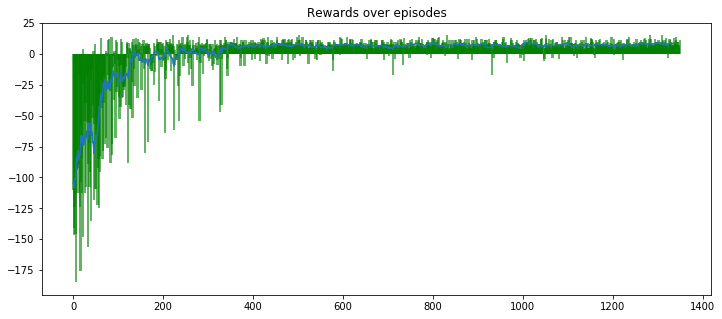

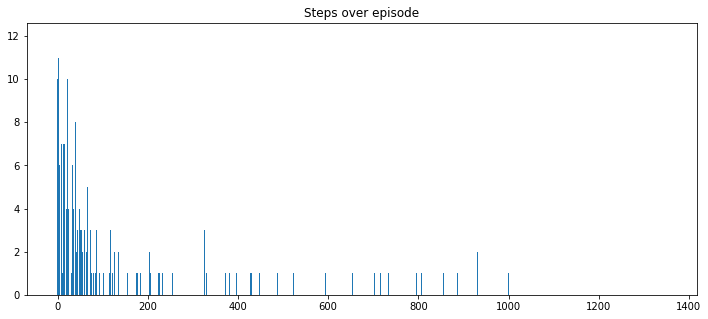

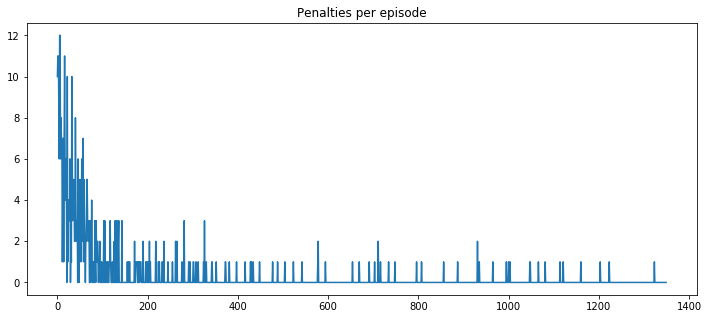

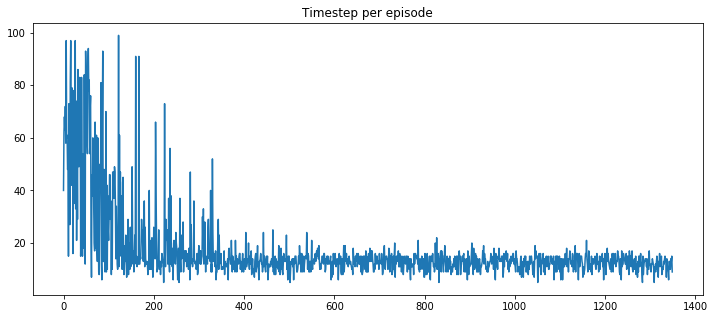

In [40]:
train()

## Program Frontend

### User Mode
Allows the customization of the parameters to change model functionality

### Time Mode
Accepts only the number of episodes desired to be run, and the optimized Q-table will be used 

In [13]:
# user_mode(
#     total_ep=,
#     max_steps=,
#     lr=,
#     gamma=,
#     epsilon=,
#     max_epsilon=,
#     min_epsilon=,
#     decay_rate=
# )

time_mode(
    steps=200
)

EPISODE:  0
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |

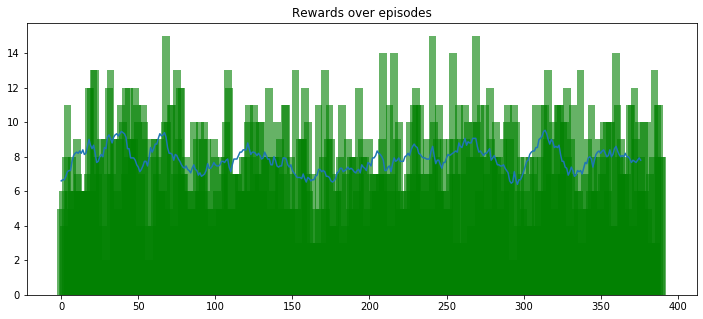

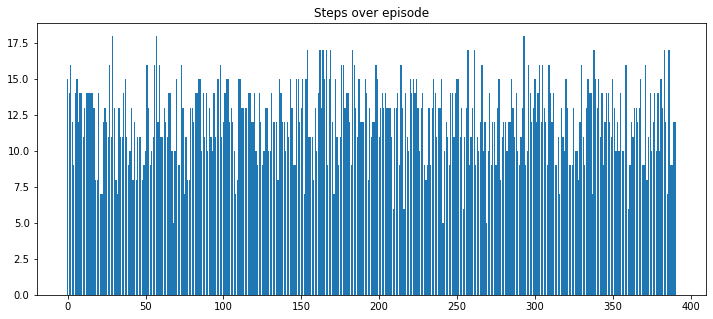

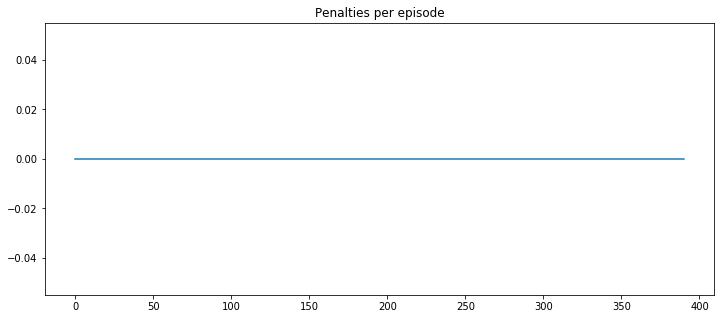

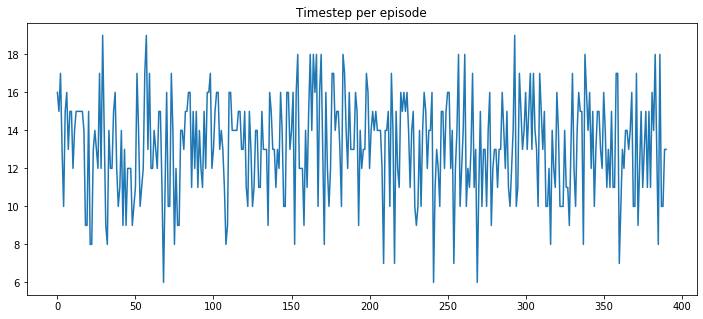

In [14]:
show_run_stats(rewards_total, penalties_per_ep_total, steps_total, timestep_per_ep_total)